# Kaggle の Kicksteter 問題
- かがわAIゼミナール基礎編の後半の課題として取り組む
- KaggleのKickstarter Projectsの2018年データを利用 https://www.kaggle.com/kemical/kickstarter-projects/

## DAY1
- 大まかな方針として，nameの文字数，category, main_category, deadline, launched, country を説明変数とし，usd_pledged_realを線形モデルで推定．そして推定結果をusd_goal_realと比較することでプロジェクトの成否を判定した．
- 結果，59.138%の正答率が得られた．

## DAY1で受けたフィードバック
- name列の文字数以外の利用法を検討しては？
- usd_pledged_realをそのまま使うとばらつきが大きいので対数変換や標準化を試しては？
- 次は、グラフを描いてみて、データの特徴を捉えましょう。

## DAY2
- 前処理として標準化を適用した
- usd_pledged_realを対数変換して考えると，標準化がきれいに効くようになった．
- countryはほとんどUSなので，まずUSだけを対象としたモデルを作ってみた．（これで無理なら全部では到底無理）
- categoryで一番多いのはProduct Designなので，まず Product Design (main categoryはDesin)だけを対象としたモデルを作ってみた．（これで無理なら複数カテでも当然苦しい）
- 汎化誤差を評価した。アンダーフィットだったので正則化までするに至らなかった．
- 多項式モデルを適用してみた（説明変数同士を掛け合わせた二次の項を説明変数に追加，5次まで追加）
- name列の文字数以外の利用法検討
    - 山崎さんのアイデアを真似て，nameのスペース数を説明変数に加えた

## DAY2で受けたフィードバック
- 標準化は、trainとtestに分けてから行った方がいいですね。
- usd_pledged_real_logの平均標準偏差を使って、usd_goal_real_log を標準化していますが、回帰で求めたpledgedを元のスケールに戻して、goalと比較すればいいのではないでしょうか？
- バギングとブースティングのどちらが優れているかは完全にケースバイケースなのでしょうか？の質問に対し，「ケースバイケースですが、一般にアダブーストに比べランダムフォレストの方が性能が高くなりやすいです。アダブーストよりも工夫が凝らされた勾配ブースティングは、ランダムフォレストよりも高い性能になりやすく、実務やkaggleではよく用いられます。」


## DAY3
- <font color="red">ランダムフォレスト</font>を試した。
    - adaboostより性能が高くなりやすいとのことなので．
    - <font color="red">これまで通り回帰モデルをメインに考えたが，分類モデルもほぼ同じコードで可能なので，比較してみた．</font>
    - 木モデル系では標準化不要なのでやめた
    - 木モデル系ではone-hotベクトルでのダミー変数化せずとも，ラベルエンコーディングで良いらしいので，次元の増えないラベルエンコーディングを適用した．
- 結果，<font color="red">分類モデルの方が性能がよく，精度は67.308%だった</color>

In [65]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
#from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import PolynomialFeatures
#from sklearn.linear_model import LinearRegression, SGDClassifier
#from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error # 回帰問題における性能評価に関する関数
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix # 回帰問題における性能評価に関する関数
from sklearn.model_selection import train_test_split, GridSearchCV # ホールドアウト法に関する関数，グリッドサーチに関する関数


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier

# 1. データの読み込み・確認
- データを読み込んだ
- 基本の情報，いくつかのデータ例，散布図行列を見た
    - 15の列があることが分かった
    - 378661個のデータがあることが分かった
    - "name"と"usd_pledged"に欠損値があることが分かった．
        - プロジェクト名の欠損値は少ないので省いて問題なさそう
        - usd_pledgedも欠損数は1%程度なので省いても問題ない．他の項目から推定できるかもしれない．
        - usd_pledgedは予想には使えないデータなのであまり問題はない可能性が高い．（ただ，ここを線形回帰で予想して，goalと比較したら成否を判定できる意味では利用価値がないとは言えない）
        - そもそも，usd_pledged_realがあるからusd_pledgedは不要とも考えられる

In [2]:
# データの読み込み
df = pd.read_csv("./ks-projects-201801.csv")

display(df.info())
print(df.isnull().sum())
display(df.describe())
display(df.head(10))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
ID                  378661 non-null int64
name                378657 non-null object
category            378661 non-null object
main_category       378661 non-null object
currency            378661 non-null object
deadline            378661 non-null object
goal                378661 non-null float64
launched            378661 non-null object
pledged             378661 non-null float64
state               378661 non-null object
backers             378661 non-null int64
country             378661 non-null object
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


None

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64


,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.00,failed,0,GB,0.00,0.00,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.00,failed,15,US,100.00,2421.00,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.00,failed,3,US,220.00,220.00,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.00,failed,1,US,1.00,1.00,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.00,canceled,14,US,1283.00,1283.00,19500.00
5,1000014025,Monarch Espresso Bar,Restaurants,Food,USD,2016-04-01,50000.0,2016-02-26 13:38:27,52375.00,successful,224,US,52375.00,52375.00,50000.00
6,1000023410,Support Solar Roasted Coffee & Green Energy! ...,Food,Food,USD,2014-12-21,1000.0,2014-12-01 18:30:44,1205.00,successful,16,US,1205.00,1205.00,1000.00
7,1000030581,Chaser Strips. Our Strips make Shots their B*tch!,Drinks,Food,USD,2016-03-17,25000.0,2016-02-01 20:05:12,453.00,failed,40,US,453.00,453.00,25000.00
8,1000034518,SPIN - Premium Retractable In-Ear Headphones w...,Product Design,Design,USD,2014-05-29,125000.0,2014-04-24 18:14:43,8233.00,canceled,58,US,8233.00,8233.00,125000.00
9,100004195,STUDIO IN THE SKY - A Documentary Feature Film...,Documentary,Film & Video,USD,2014-08-10,65000.0,2014-07-11 21:55:48,6240.57,canceled,43,US,6240.57,6240.57,65000.00


In [3]:

# 時間がかかるので基本実行しない。

# 散布図行列のプロット
#pd.plotting.scatter_matrix(df, figsize=(15,15))
#plt.show()

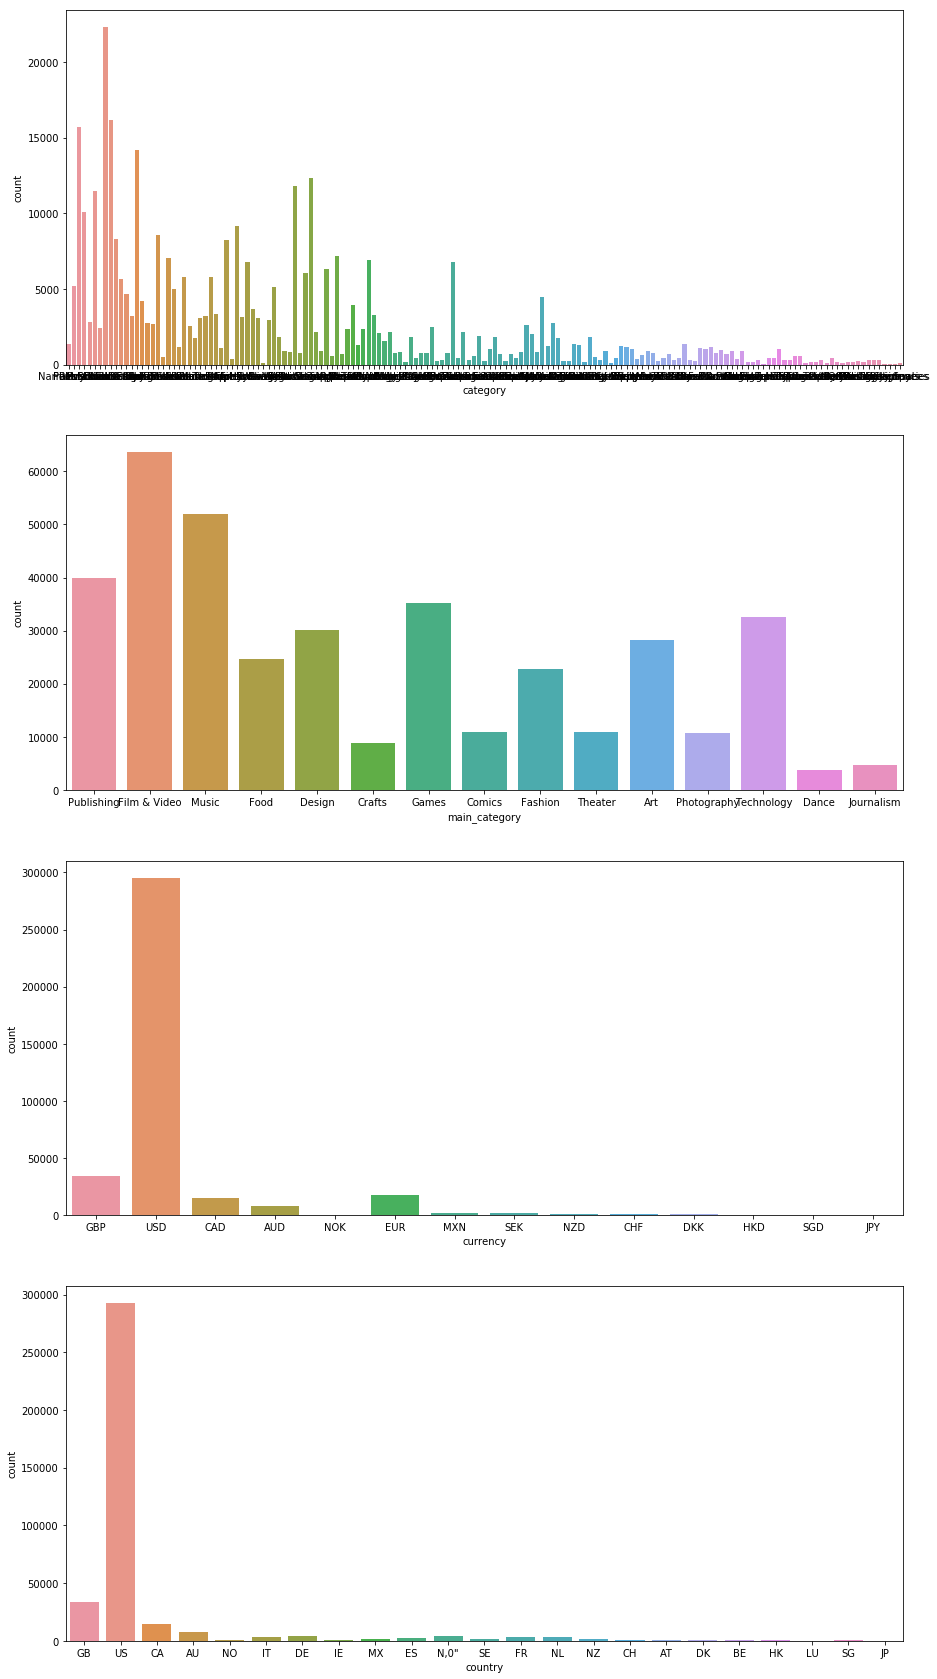

Product Design       22314
Documentary          16139
Music                15727
Tabletop Games       14180
Shorts               12357
Video Games          11830
Food                 11493
Film & Video         10108
Fiction               9169
Fashion               8554
Nonfiction            8318
Art                   8253
Apparel               7166
Theater               7057
Technology            6930
Rock                  6758
Children's Books      6756
Apps                  6345
Publishing            6018
Webseries             5762
Photography           5752
Indie Rock            5657
Narrative Film        5188
Web                   5153
Comics                4996
Crafts                4664
Country & Folk        4451
Design                4199
Hip-Hop               3912
Hardware              3663
                     ...  
Couture                275
Blues                  268
Animals                255
Fabrication Tools      250
Printing               238
Makerspaces            238
M

In [4]:
fig,ax = plt.subplots(4,1,figsize=(15,30))
sns.countplot(df.category,ax=ax[0])
sns.countplot(df.main_category,ax=ax[1])
sns.countplot(df.currency,ax=ax[2])
sns.countplot(df.country,ax=ax[3])
plt.show()
df.category.value_counts()

# 調査（Kickstarter本家サイトの利用者向け情報より）
- 「30日以下のプロジェクトは成功率が高い」⇒deadlineからlaunchedを引いた値が有効そう。（https://www.kickstarter.com/help/handbook/funding?ref=handbook_rewards）
- 「一人当たりの平均的な支援額は25ドル」⇒活かし方は不明だが、一応メモしておく。（https://www.kickstarter.com/help/handbook/rewards?ref=handbook_story）


# 2. 作戦


- stateを推測する．
- usd_pledged_realを回帰で求めて，それをusd_goal_realと比較してstateを推測することとする．
    - 実際のstateの決まり方に従った形．
    - 私の業務ではロボットの制御をしたく，分類よりも回帰に興味があるため．
- 学習モデルはランダムフォレストを使う
    - 質問シートにてadaboostより性能が良いことが多いとのことだったので．
    - ランダムフォレストで直接stateを推定するのもコードがほとんど同じになるので，ついでに比較してみる．
- 講座中に，successfulとfalse以外は省いて考えると良いとアドバイスがあったので従う．
- IDは使わない．
- 面白そうなnameは成功しそうだが、その解析は大変そう。とりあえず文字数が多ければ説明がしっかりしている、あるいは短ければシンプルで力強い、などの情報がありそうなので、文字数だけ使ってみる。
    - 山崎さんのアイデアのスペース数を単語数とみなして説明変数に加えるのを追加（DAY2）
- usd_pledged と usd_pledged_real はデータ例を見るとほぼ同じ値で，散布図行列でも45度の分布したデータが多い．ただ2番目のデータ例ではusd_pledged_realの方が正しそうであることと，usd_pledgedは比較的欠損値が多いことと，usd_goal_realと同じAPIで通貨変化をしているのがusd_pledged_realであることから，usd_pledgedは利用しない．（どっちが正しいかはより詳しい検証が必要かもしれない．）
- 通貨はすべて米ドルでそろえた方が比較しやすいので，米ドルで考える．
    - このためgoal, pledgedは見ない（Fixer.io APIの変換がうまくいっているかの検証を後で行う余裕があれば，そのために使うかも．）．
    - currencyは地域を反映するのに使えるが，それはcountryでわかるので，currencyは使わない．
- 日付はそのままでは解析しにくいので変換する．
    - 日付のままでは扱いにくいので2000年1月0日からの経過日数で表現する．（kickstarterの設立は2009年）
    - 年を追うごとにkickstarterが盛り上がっている可能性もあるか？
- categoryはラベルエンコードする．
    - 木モデル系はダミー変数化でなくラベルエンコーディングで良いことが多いらしいので
- main_categoryはcategoryでフォローされていると考えて削除する
- 変数間に相関があると良くないということだったので，明らかに相関が出るだろうdeadlineとlaunchedは扱いを考える．
    - 上記Kickstarterのサイトの調査結果からdeadline - launchedには価値があるようなので，これをproject_lengthとして新たな説明変数とする．
    - 無相関化は線形変換ということなので，線形変換で問題が解消する場合がある．つまり上記の差分を取るだけの線形な処理でもうまく動く可能性がある．
    - 年を追うごとの変化も考えられるので，どちらかは残す．（launchedを残した）



## ここまでの変数のまとめ

|目標変数|説明変数|
|:---|:---|
|usd_pledged_real|name<br>deadline<br>launched<br>usd_goal_real|

使わない行：
- nameに欠損がある行（ごく僅か）

|列名|列名の意味|説明変数に使えるか？|目標変数に指定|説明変数に指定|備考|
|:---:|:---:|:---:|:---:|:---:|:---:|
|ID|ID|o|x|x|-|
|name|プロジェクト名|o|x|o|文字数と単語数（スペース数）を説明変数として利用|
|category|カテゴリー|o|x|-|Designだけを見る|
|main_category|メインカテゴリー|o|x|-|Product Designだけを見る|
|currency|プロジェクト通貨|o|x|x|countryと同様と考えた|
|deadline|締め切り|o|x|o|2000年1月0日からの日数に変換後，launchedとの差分を取った別の説明変数project_lengthに変更を検討|
|goal|目標額|o|x|x|usd_goal_realを利用|
|launched|公開日|o|x|o|2000年1月0日からの日数に変換．時刻は今は捨てる|
|pledged|支援額|x|x|x|-|
|state|成否|x|(o)|x|分類問題の目標変数であるが，回帰問題として考える中では使わない|
|backers|支援者数|x|x|x|-|
|country|国|o|x|-|とりあえずUSだけを見る|
|usd_pledged|支援額(\$)|x|x|x|usd_pledged_realの方を使う|
|usd_pledged_real|支援額(\$)|x|o|x|回帰の目標変数とする|
|usd_goal_real|目標額(\$)|o|x|o|-|



# 3. 前処理
- 使わない列を削除
- successfulとfalse以外のデータは捨てる
- successful,falseをTrue,Falseに変換
- nameに欠損値のあるデータはとりあえず捨てる
- nameを文字数に変換
- nameを単語数（スペース数）に変換
- deadlineとlaunchedを2000年1月0日からの日数に変換
- category，countryをラベルエンコード

In [5]:
from sklearn.preprocessing import LabelEncoder



# 使わない列を削除
df = df.drop(columns=["ID","currency","goal","pledged","backers","usd pledged","main_category"])

# successfulとfailed以外は除く
df = df[ (df["state"]=="successful") | (df["state"]=="failed") ]
# successful, failed をブール型に加工
df["state"] = df["state"]=="successful"

# (name が)欠損しているデータを除く
df = df.dropna()


# nameから文字数と単語数をカウントし，それぞれ説明変数にする．
df["name_len"] = df["name"].apply(len) # 文字数
df["name_words"] = df["name"].str.count(" ") # 単語数（≒スペース数）
df = df.drop(columns="name") # 元のname列を削除
    
# 日付を2000年1月0日からの経過日数に変換する関数を定義
# 面倒なのですべて1年は365日で，1月は30日として粗く変換
# 20yy-mm-dd を仮定
def date2days(s):
    y = int(s[2])*10 + int(s[3])
    m = int(s[5])*10 + int(s[6])
    d = int(s[8])*10 + int(s[9])
    days = y*365 + m*30 + d
    return days
# deadline
df["deadline_num"] = df["deadline"].apply(date2days)
df = df.drop(columns="deadline")
#launched
df["launched_num"] = df["launched"].apply(date2days)
df = df.drop(columns="launched")

# category, countryをラベルエンコーディング（木モデルを使うのでこれでOK）
le = LabelEncoder()
df.category = le.fit_transform(df.category)
df.country = le.fit_transform(df.country)



## deadlineとlaunchedの相関
- 明らかにdeadlineとlaunchedには相関が予想される．
- 時期によって kichstarter の盛り上がりなどがあり得るので，プロジェクトが行われた時期は意味があると考えられる．
- 調査した通り，deadlineからlaunchedを引いた値は（プロジェクトの開始時期とは別で）意味があると考えられる．
-  deadline - lauchedが相関があるかどうかを調べる．

結果：
- 散布図行列を出してみたところ，deadlineとlaunchedには強い相関が見られた．
- 新しい説明変数project_lengthはdeadlineやlaunchedと相関が見られなかった．なので，deadlineを削除し，project_lengthを新たに使うこととする．

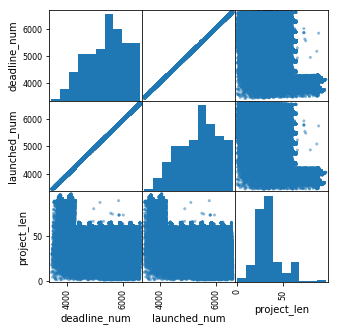

In [6]:
# deadlineからlaunchedを引いて募集期間 project_length 列を作成
df["project_len"] = df["deadline_num"].values - df["launched_num"].values

# 散布図行列により相関を確認
pd.plotting.scatter_matrix(df[["deadline_num","launched_num","project_len"]], figsize=(5,5))
plt.show()

In [7]:
# 使わない列を削除
df = df.drop(columns=["deadline_num"])

並びを整える

In [8]:
# 並び替え
df=df.reindex(columns=["state","usd_pledged_real","name_len","name_words","category","launched_num","project_len","country","usd_goal_real"])


df.head()

,state,usd_pledged_real,name_len,name_words,category,launched_num,project_len,country,usd_goal_real
0,False,0.0,31,5,108,5726,58,9,1533.95
1,False,2421.0,45,7,93,6477,59,22,30000.00
2,False,220.0,14,2,93,4787,44,22,45000.00
3,False,1.0,49,6,90,4487,29,22,5000.00
5,True,52375.0,20,2,123,5926,35,22,50000.00


## 訓練データとテストデータに分ける

In [12]:
y = df.state.values
X = df.drop(['state'], axis=1).values

# ホールドアウト法
test_size = 0.2        # 全データのうち、何%をテストデータにするか（今回は20%に設定）
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=1234) # ホールドアウト法を実行（テストデータはランダム選択）

# 回帰モデル用の調整
X0_train = X_train[:,1:]
y0_train = X_train[:,0].reshape(-1)
X0_test  = X_test[:,1:]
y0_test  = X_test[:,0].reshape(-1)
X0_col_goal = 6 # X0の6列目がgoalを表している．（回帰モデルを使う場合は推定値とgoalの値を比較する．）


print("X_train:")
print(X_train[0:4,:])
print("y_train:")
print(y_train[0:4])
#print("X_test:")
#print(X_test[0:4,:])
#print("y_test:")
#print(y_test[0:4])

print("X0_train:")
print(X0_train[0:4,:])
print("y0_train:")
print(y0_train[0:4])
#print("X0_test:")
#print(X0_test[0:4,:])
#print("y0_test:")
#print(y0_test[0:4])
print("X0_train(goal):")
print(X0_train[0:4,X0_col_goal])



X_train:
[[7.10400e+03 5.90000e+01 8.00000e+00 1.13000e+02 5.81500e+03 4.00000e+01
  2.20000e+01 4.00000e+04]
 [2.00000e+00 1.80000e+01 2.00000e+00 8.70000e+01 5.94000e+03 2.90000e+01
  2.20000e+01 1.00000e+03]
 [1.07000e+00 3.50000e+01 6.00000e+00 5.00000e+00 6.31000e+03 2.90000e+01
  1.10000e+01 1.06980e+02]
 [9.45284e+03 1.10000e+01 1.00000e+00 1.39000e+02 5.37200e+03 2.90000e+01
  3.00000e+00 8.99928e+03]]
y_train:
[False False False  True]
X0_train:
[[5.90000e+01 8.00000e+00 1.13000e+02 5.81500e+03 4.00000e+01 2.20000e+01
  4.00000e+04]
 [1.80000e+01 2.00000e+00 8.70000e+01 5.94000e+03 2.90000e+01 2.20000e+01
  1.00000e+03]
 [3.50000e+01 6.00000e+00 5.00000e+00 6.31000e+03 2.90000e+01 1.10000e+01
  1.06980e+02]
 [1.10000e+01 1.00000e+00 1.39000e+02 5.37200e+03 2.90000e+01 3.00000e+00
  8.99928e+03]]
y0_train:
[7.10400e+03 2.00000e+00 1.07000e+00 9.45284e+03]
X0_train(goal):
[40000.    1000.     106.98  8999.28]


## 前処理が終わったところで，もう一度，各種情報を見てみる．
- 散布図行列を見たところ残念ながら，usd_pledged_realとその他の説明変数に関連があるように見えない．．．
- プロジェクト名の長さや単語数，募集開始日，募集期間，目標金額だけで本当に金額を推定できるものか．．．？


In [13]:
display(df.info())
print(df.isnull().sum())
display(df.describe())
display(df.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331672 entries, 0 to 378660
Data columns (total 9 columns):
state               331672 non-null bool
usd_pledged_real    331672 non-null float64
name_len            331672 non-null int64
name_words          331672 non-null int64
category            331672 non-null int32
launched_num        331672 non-null int64
project_len         331672 non-null int64
country             331672 non-null int32
usd_goal_real       331672 non-null float64
dtypes: bool(1), float64(2), int32(2), int64(4)
memory usage: 20.6 MB


None

state               0
usd_pledged_real    0
name_len            0
name_words          0
category            0
launched_num        0
project_len         0
country             0
usd_goal_real       0
dtype: int64


,usd_pledged_real,name_len,name_words,category,launched_num,project_len,country,usd_goal_real
count,3.316720e+05,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,331672.000000,3.316720e+05
mean,9.943549e+03,34.220335,4.654746,80.292268,5383.478741,33.805853,18.994838,4.150966e+04
std,9.673337e+04,15.961502,2.784668,45.069070,702.703084,12.789145,6.193820,1.108935e+06
min,0.000000e+00,1.000000,0.000000,0.000000,3426.000000,1.000000,0.000000,1.000000e-02
25%,5.000000e+01,21.000000,2.000000,39.000000,4864.000000,29.000000,22.000000,2.000000e+03
50%,7.880000e+02,33.000000,4.000000,85.000000,5446.000000,30.000000,22.000000,5.000000e+03
75%,4.608000e+03,48.000000,7.000000,119.000000,5937.000000,36.000000,22.000000,1.500000e+04
max,2.033899e+07,85.000000,40.000000,158.000000,6594.000000,97.000000,22.000000,1.663614e+08


,state,usd_pledged_real,name_len,name_words,category,launched_num,project_len,country,usd_goal_real
0,False,0.0,31,5,108,5726,58,9,1533.95
1,False,2421.0,45,7,93,6477,59,22,30000.00
2,False,220.0,14,2,93,4787,44,22,45000.00
3,False,1.0,49,6,90,4487,29,22,5000.00
5,True,52375.0,20,2,123,5926,35,22,50000.00
6,True,1205.0,60,8,58,5471,20,22,1000.00
7,False,453.0,49,7,41,5901,46,22,25000.00
10,False,0.0,19,3,95,5024,30,3,2406.39
11,True,12700.0,16,3,72,4844,29,22,12500.00
12,False,0.0,18,2,32,5382,30,22,5000.00


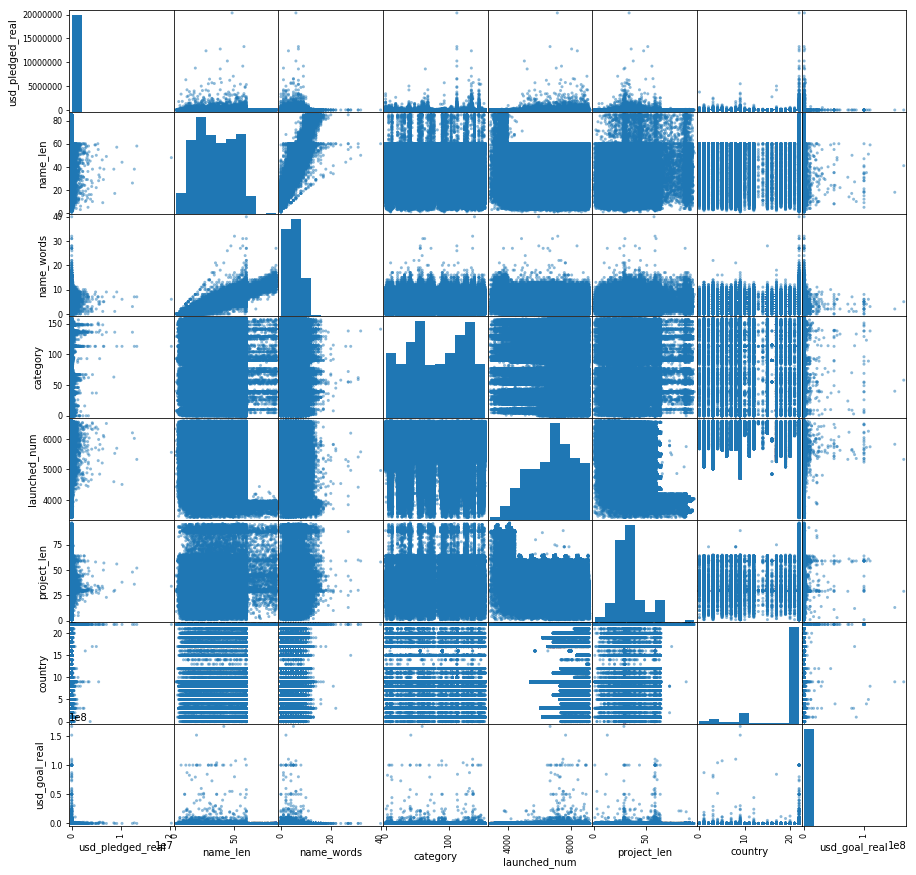

In [14]:
# 重いので普段は動かさない

#pd.plotting.scatter_matrix(df.drop(["state"],axis=1), figsize=(15,15))
#plt.show()

# 4. 学習と評価

- <font color = "red">ランダムフォレスト</font>による推定を行った．
- 以下の<font color = "red">2つのモデルでの結果を比較</font>した
    - usd_pledged_realを推定し，それを用いてstateを推定<font color = "red">（回帰モデル）</font>
        - usd_pledged_realを推定するランダムフォレストを学習し，その後，usd_goal_realと比較することで成否を判定．
        - これまで実施した線形回帰モデル，説明変数同士の積を計算して説明変数に加えた線形回帰モデル，より高次まで上げた多項式を考えた線形回帰モデルの結果とも比較する．
    - 直接stateを推定<font color = "red">（分類モデル）</font>
        - stateを推定するランダムフォレストを学習する．
        - usd_pledged_realを省く．
- グリッドサーチによりハイパーパラメータの最適化を行った．
    - n_estimators：講座で100～1000本くらいを使うことが多いとのことだったので，200,400,800をグリッドサーチで試した．⇒両モデルとも800が選ばれた．
    - max_depth：今，7つの説明変数があるので，全部使うと14の条件分けになる．6,10,14をグリッドサーチで試した．⇒両モデルとも14が選ばれた．
    - min_samples_split：302752個の訓練データがあり，その1%を考えると3027個である．30,300,3000データをグリッドサーチで試した．⇒両モデルとも30が選ばれた．
    - min_samples_leaf：min_samples_splitと同じく，30,300,3000データをグリッドサーチで試した．⇒両モデルとも30が選ばれた．
- グリッドサーチで選択肢の端の値が選ばれたので，更にその先をグリッドサーチした．
    - n_estimators：800が選ばれていたので，1200と1600も試した．⇒両モデルとも1200が選ばれた．
    - max_depth：14が選ばれていたので，20と26も試した．⇒両モデルとも20が選ばれた．
    - min_samples_split：30が選ばれていたので，3と10も試した．⇒回帰は3が選ばれた．分類は10が選ばれた．
    - min_samples_leaf：30が選ばれていたので，3と10も試した．⇒回帰は10が選ばれた．分類は10が選ばれた．
- ホールドアウト法による汎化誤差で評価した．
- 結果，<font color="red">回帰モデルの精度は63.190%，分類モデルの精度は67.308%で，分類モデルの方が精度が良かった．</font>

|　|回帰モデルを利用した場合|分類モデルを利用した場合|
|:---:|:---:|:---:|
|accuracy|63.190%|67.308%|
|precision|56.810%|62.456%|
|recall|36.874%|47.734%|
|F1|44.721%|54.111%|

## 4.1 usd_pledged_realを推定し，それを用いてstateを推定（回帰モデル）

In [57]:
# グリッドサーチ


#%%time
t_start = time.time()# 処理時間計測用

model = RandomForestRegressor(random_state=1234, n_jobs = 4)
parameters = {'n_estimators':[200,400,800], 'max_depth':[6,10,14], "min_samples_leaf":[30,300,3000], "min_samples_split":[30,300,3000]} 
gs = GridSearchCV(model, parameters, cv=3, n_jobs=2)
gs.fit(X0_train, y0_train)
print(gs.best_params_, gs.best_score_)


t_end = time.time()# 処理時間計測用
print(t_end - t_start, '秒')# 処理時間
print("="， (t_end - t_start)/60.0, '分')# 処理時間

{'max_depth': 14, 'min_samples_leaf': 30, 'min_samples_split': 30, 'n_estimators': 800} 0.0632323741437832
6642.250665903091 秒


In [60]:
# 最適パラメータでの値の予測
t_start = time.time()# 処理時間計測用


# 学習
model = RandomForestRegressor(n_estimators=800, 
                              max_depth=14,
                              min_samples_leaf=30, 
                              min_samples_split=30, 
                              random_state=1234,
                              n_jobs = -1)
model.fit(X0_train, y0_train)

# 値を予測
y0_train_pred = model.predict(X0_train)
y0_test_pred  = model.predict(X0_test) 

# MSE, MAE, RMSEを計算
mse_train = mean_squared_error(y0_train, y0_train_pred) 
mae_train = mean_absolute_error(y0_train, y0_train_pred) 
rmse_train = np.sqrt(mse_train)
print("MSE(train) = %s"%round(mse_train,3) )  
print("MAE(trian) = %s"%round(mae_train,3) )
print("RMSE(train) = %s"%round(rmse_train, 3) )
mse_test = mean_squared_error(y0_test, y0_test_pred) 
mae_test = mean_absolute_error(y0_test, y0_test_pred) 
rmse_test = np.sqrt(mse_test)
print("MSE(test) = %s"%round(mse_test,3) )  
print("MAE(test) = %s"%round(mae_test,3) )
print("RMSE(test) = %s"%round(rmse_test, 3) )

t_end = time.time()# 処理時間計測用
#print(t_end - t_start, '秒')# 処理時間
print((t_end - t_start)/60.0, '分')# 処理時間

MSE(train) = 7725483709.954
MAE(trian) = 11609.405
RMSE(train) = 87894.731
MSE(test) = 10539468637.606
MAE(test) = 12239.588
RMSE(test) = 102661.914
114.99181175231934 秒


### グリッドサーチで候補の端っこばかりが選ばれたので，一応その先も少し探索してみる．

In [61]:
# 回帰モデルの結果y_predとusd_goal_realを比較して成否を判定
y_train_pred = np.where( y0_train_pred >= X0_train[:,X0_col_goal].reshape(-1), True, False ) # X0のX0_col_goal列目が usd_goal_real
y_test_pred = np.where( y0_test_pred >= X0_test[:,X0_col_goal], True, False ) # X0のX0_col_goal列目が usd_goal_real


#################################################################################
print("訓練誤差")
# 正答率を計算
accuracy_train =  accuracy_score(y_train, y_train_pred)
print('正答率（Accuracy） = {:.3%}'.format(accuracy_train))
# Precision, Recall, F1-scoreを計算
precision_train, recall_train, f1_score_train, _ = precision_recall_fscore_support(y_train, y_train_pred)
# カテゴリ「成功」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3%}'.format(precision_train[1]))
print('再現率（Recall） = {:.3%}'.format(recall_train[1]))
print('F1値（F1-score） = {:.3%}'.format(f1_score_train[1]))
# 予測値と正解のクロス集計
conf_mat_train = pd.DataFrame(confusion_matrix(y_train, y_train_pred), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
display(conf_mat_train)
#################################################################################
print("汎化誤差")
# 正答率を計算
accuracy_test =  accuracy_score(y_test, y_test_pred)
print('正答率（Accuracy） = {:.3%}'.format(accuracy_test))
# Precision, Recall, F1-scoreを計算
precision_test, recall_test, f1_score_test, _ = precision_recall_fscore_support(y_test, y_test_pred)
# カテゴリ「成功」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3%}'.format(precision_test[1]))
print('再現率（Recall） = {:.3%}'.format(recall_test[1]))
print('F1値（F1-score） = {:.3%}'.format(f1_score_test[1]))
# 予測値と正解のクロス集計
conf_mat_test = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
display(conf_mat_test)

訓練誤差
正答率（Accuracy） = 63.661%
適合率（Precision） = 58.074%
再現率（Recall） = 36.068%
F1値（F1-score） = 44.499%


,予測 = failed,予測 = successful
正解 = failed,130261,27906
正解 = successful,68516,38654


汎化誤差
正答率（Accuracy） = 62.365%
適合率（Precision） = 55.436%
再現率（Recall） = 34.664%
F1値（F1-score） = 42.655%


,予測 = failed,予測 = successful
正解 = failed,32085,7464
正解 = successful,17501,9285


In [63]:
# グリッドサーチ
# 候補の端っこばかりが選ばれたので，その先も少し探索してみる．


#%%time
t_start = time.time()# 処理時間計測用

model = RandomForestRegressor(random_state=1234, n_jobs = 4)
parameters = {'n_estimators':[1200,1600], 'max_depth':[20,26], "min_samples_leaf":[3,10], "min_samples_split":[3,10]} 
gs = GridSearchCV(model, parameters, cv=3, n_jobs=2)
gs.fit(X0_train, y0_train)
print(gs.best_params_, gs.best_score_)


t_end = time.time()# 処理時間計測用
#print(t_end - t_start, '秒')# 処理時間
print((t_end - t_start)/60.0, '分')# 処理時間

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\externals\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


{'max_depth': 20, 'min_samples_leaf': 10, 'min_samples_split': 3, 'n_estimators': 1200} 0.056522717927180145
132.63355537255606 分


In [76]:
# 最適パラメータでの値の予測
t_start = time.time()# 処理時間計測用


# 学習
model = RandomForestRegressor(n_estimators=1200, 
                              max_depth=20,
                              min_samples_leaf=10, 
                              min_samples_split=3, 
                              random_state=1234,
                              n_jobs = -1)
model.fit(X0_train, y0_train)

# 値を予測
y0_train_pred = model.predict(X0_train)
y0_test_pred  = model.predict(X0_test) 

# MSE, MAE, RMSEを計算
mse_train = mean_squared_error(y0_train, y0_train_pred) 
mae_train = mean_absolute_error(y0_train, y0_train_pred) 
rmse_train = np.sqrt(mse_train)
print("MSE(train) = %s"%round(mse_train,3) )  
print("MAE(trian) = %s"%round(mae_train,3) )
print("RMSE(train) = %s"%round(rmse_train, 3) )
mse_test = mean_squared_error(y0_test, y0_test_pred) 
mae_test = mean_absolute_error(y0_test, y0_test_pred) 
rmse_test = np.sqrt(mse_test)
print("MSE(test) = %s"%round(mse_test,3) )  
print("MAE(test) = %s"%round(mae_test,3) )
print("RMSE(test) = %s"%round(rmse_test, 3) )

t_end = time.time()# 処理時間計測用
#print(t_end - t_start, '秒')# 処理時間
print((t_end - t_start)/60.0, '分')# 処理時間

MSE(train) = 6864548443.121
MAE(trian) = 10581.873
RMSE(train) = 82852.571
MSE(test) = 10509568476.123
MAE(test) = 12248.612
RMSE(test) = 102516.186
3.604204269250234 分


In [77]:
# 回帰モデルの結果y_predとusd_goal_realを比較して成否を判定
y_train_pred = np.where( y0_train_pred >= X0_train[:,X0_col_goal].reshape(-1), True, False ) # X0のX0_col_goal列目が usd_goal_real
y_test_pred = np.where( y0_test_pred >= X0_test[:,X0_col_goal], True, False ) # X0のX0_col_goal列目が usd_goal_real


#################################################################################
print("訓練誤差")
# 正答率を計算
accuracy_train =  accuracy_score(y_train, y_train_pred)
print('正答率（Accuracy） = {:.3%}'.format(accuracy_train))
# Precision, Recall, F1-scoreを計算
precision_train, recall_train, f1_score_train, _ = precision_recall_fscore_support(y_train, y_train_pred)
# カテゴリ「成功」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3%}'.format(precision_train[1]))
print('再現率（Recall） = {:.3%}'.format(recall_train[1]))
print('F1値（F1-score） = {:.3%}'.format(f1_score_train[1]))
# 予測値と正解のクロス集計
conf_mat_train = pd.DataFrame(confusion_matrix(y_train, y_train_pred), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
display(conf_mat_train)
#################################################################################
print("汎化誤差")
# 正答率を計算
accuracy_test =  accuracy_score(y_test, y_test_pred)
print('正答率（Accuracy） = {:.3%}'.format(accuracy_test))
# Precision, Recall, F1-scoreを計算
precision_test, recall_test, f1_score_test, _ = precision_recall_fscore_support(y_test, y_test_pred)
# カテゴリ「成功」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3%}'.format(precision_test[1]))
print('再現率（Recall） = {:.3%}'.format(recall_test[1]))
print('F1値（F1-score） = {:.3%}'.format(f1_score_test[1]))
# 予測値と正解のクロス集計
conf_mat_test = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
display(conf_mat_test)

訓練誤差
正答率（Accuracy） = 68.046%
適合率（Precision） = 66.289%
再現率（Recall） = 42.497%
F1値（F1-score） = 51.791%


,予測 = failed,予測 = successful
正解 = failed,135006,23161
正解 = successful,61626,45544


汎化誤差
正答率（Accuracy） = 63.190%
適合率（Precision） = 56.810%
再現率（Recall） = 36.874%
F1値（F1-score） = 44.721%


,予測 = failed,予測 = successful
正解 = failed,32040,7509
正解 = successful,16909,9877


## 4.2 直接stateを推定（分類モデル）

In [70]:
# グリッドサーチ


#%%time
t_start = time.time()# 処理時間計測用

model = RandomForestClassifier(random_state=1234, n_jobs = 4)
parameters = {'n_estimators':[200,400,800], 'max_depth':[6,10,14], "min_samples_leaf":[30,300,3000], "min_samples_split":[30,300,3000]} 
gs = GridSearchCV(model, parameters, cv=3, n_jobs=2)
gs.fit(X0_train, y_train)

# 結果
print("optimal:")
print(gs.best_params_, gs.best_score_)

t_end = time.time()# 処理時間計測用
#print(t_end - t_start, '秒')# 処理時間
print((t_end - t_start)/60.0, '分')# 処理時間


optimal:
{'max_depth': 14, 'min_samples_leaf': 30, 'min_samples_split': 30, 'n_estimators': 800} 0.6689606048157626
3848.836848258972 秒


In [74]:
# 学習
model = RandomForestClassifier(n_estimators=800, 
                              max_depth=14,
                              min_samples_leaf=30, 
                              min_samples_split=30, 
                              random_state=1234,
                              n_jobs = -1)
model.fit(X0_train, y_train)

# 値を予測
y_train_pred = model.predict(X0_train)
y_test_pred  = model.predict(X0_test) 

# 評価
#################################################################################
print("訓練誤差")
# 正答率を計算
accuracy_train =  accuracy_score(y_train, y_train_pred)
print('正答率（Accuracy） = {:.3%}'.format(accuracy_train))
# Precision, Recall, F1-scoreを計算
precision_train, recall_train, f1_score_train, _ = precision_recall_fscore_support(y_train, y_train_pred)
# カテゴリ「成功」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3%}'.format(precision_train[1]))
print('再現率（Recall） = {:.3%}'.format(recall_train[1]))
print('F1値（F1-score） = {:.3%}'.format(f1_score_train[1]))
# 予測値と正解のクロス集計
conf_mat_train = pd.DataFrame(confusion_matrix(y_train, y_train_pred), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
display(conf_mat_train)
#################################################################################
print("汎化誤差")
# 正答率を計算
accuracy_test =  accuracy_score(y_test, y_test_pred)
print('正答率（Accuracy） = {:.3%}'.format(accuracy_test))
# Precision, Recall, F1-scoreを計算
precision_test, recall_test, f1_score_test, _ = precision_recall_fscore_support(y_test, y_test_pred)
# カテゴリ「成功」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3%}'.format(precision_test[1]))
print('再現率（Recall） = {:.3%}'.format(recall_test[1]))
print('F1値（F1-score） = {:.3%}'.format(f1_score_test[1]))
# 予測値と正解のクロス集計
conf_mat_test = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
display(conf_mat_test)

訓練誤差
正答率（Accuracy） = 69.250%
適合率（Precision） = 66.938%
再現率（Recall） = 47.162%
F1値（F1-score） = 55.336%


,予測 = failed,予測 = successful
正解 = failed,133203,24964
正解 = successful,56627,50543


汎化誤差
正答率（Accuracy） = 66.797%
適合率（Precision） = 62.544%
再現率（Recall） = 44.310%
F1値（F1-score） = 51.872%


,予測 = failed,予測 = successful
正解 = failed,32441,7108
正解 = successful,14917,11869


### グリッドサーチで候補の端っこばかりが選ばれたので，一応その先も少し探索してみる．

In [72]:
# グリッドサーチ


#%%time
t_start = time.time()# 処理時間計測用

model = RandomForestClassifier(random_state=1234, n_jobs = 4)
parameters = {'n_estimators':[1200,1600], 'max_depth':[20,26], "min_samples_leaf":[3,10], "min_samples_split":[3,10]} 
gs = GridSearchCV(model, parameters, cv=3, n_jobs=2)
gs.fit(X_train[:,1:], y_train)# X[0,:]はusd_pledged_real

# 結果
print("optimal:")
print(gs.best_params_, gs.best_score_)

t_end = time.time()# 処理時間計測用
#print(t_end - t_start, '秒')# 処理時間
print((t_end - t_start)/60.0, '分')# 処理時間


optimal:
{'max_depth': 20, 'min_samples_leaf': 3, 'min_samples_split': 10, 'n_estimators': 1200} 0.6744894228848596
69.13849546511968 分


In [75]:
# 学習
model = RandomForestClassifier(n_estimators=1200, 
                              max_depth=20,
                              min_samples_leaf=3, 
                              min_samples_split=10, 
                              random_state=1234,
                              n_jobs = -1)
model.fit(X0_train, y_train)

# 値を予測
y_train_pred = model.predict(X0_train)
y_test_pred  = model.predict(X0_test) 

# 評価
#################################################################################
print("訓練誤差")
# 正答率を計算
accuracy_train =  accuracy_score(y_train, y_train_pred)
print('正答率（Accuracy） = {:.3%}'.format(accuracy_train))
# Precision, Recall, F1-scoreを計算
precision_train, recall_train, f1_score_train, _ = precision_recall_fscore_support(y_train, y_train_pred)
# カテゴリ「成功」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3%}'.format(precision_train[1]))
print('再現率（Recall） = {:.3%}'.format(recall_train[1]))
print('F1値（F1-score） = {:.3%}'.format(f1_score_train[1]))
# 予測値と正解のクロス集計
conf_mat_train = pd.DataFrame(confusion_matrix(y_train, y_train_pred), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
display(conf_mat_train)
#################################################################################
print("汎化誤差")
# 正答率を計算
accuracy_test =  accuracy_score(y_test, y_test_pred)
print('正答率（Accuracy） = {:.3%}'.format(accuracy_test))
# Precision, Recall, F1-scoreを計算
precision_test, recall_test, f1_score_test, _ = precision_recall_fscore_support(y_test, y_test_pred)
# カテゴリ「成功」に関するPrecision, Recall, F1-scoreを表示
print('適合率（Precision） = {:.3%}'.format(precision_test[1]))
print('再現率（Recall） = {:.3%}'.format(recall_test[1]))
print('F1値（F1-score） = {:.3%}'.format(f1_score_test[1]))
# 予測値と正解のクロス集計
conf_mat_test = pd.DataFrame(confusion_matrix(y_test, y_test_pred), 
                        index=['正解 = failed', '正解 = successful'], 
                        columns=['予測 = failed', '予測 = successful'])
display(conf_mat_test)

訓練誤差
正答率（Accuracy） = 82.685%
適合率（Precision） = 85.015%
再現率（Recall） = 69.354%
F1値（F1-score） = 76.390%


,予測 = failed,予測 = successful
正解 = failed,145066,13101
正解 = successful,32843,74327


汎化誤差
正答率（Accuracy） = 67.308%
適合率（Precision） = 62.456%
再現率（Recall） = 47.734%
F1値（F1-score） = 54.111%


,予測 = failed,予測 = successful
正解 = failed,31863,7686
正解 = successful,14000,12786


# 5 結論

|項目|本プログラム|
|:---:|:---:|
|特徴量|nameの長さ<br>nameの中のスペース数<br>category（ラベルエンコーディング）<br>launched（2000年1月0日からの経過日数）<br>deadlineからlaunchedを引いた日数<br>country（ラベルエンコーディング）<br>usd_goal_real|
|モデル|ランダムフォレスト（分類モデルで直接stateを推定する方法）|
|結果|精度は67.308%だった|
